In [3]:
#https://storage.googleapis.com/kaggle-forum-message-attachments/346809/9660/tracklet_seeding.py
import os
from trackml.score  import score_event
from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [4]:
#https://www.kaggle.com/cpmpml/a-faster-python-scoring-function
def score_event_fast_3(truth, submission):
    truth = truth[['hit_id', 'particle_id', 'weight']].merge(submission, how='left', on='hit_id')
    truth['count_both'] = truth.groupby(['track_id', 'particle_id']).hit_id.transform('count')    
    truth['count_particle'] = truth.groupby(['particle_id']).hit_id.transform('count')
    truth['count_track'] = truth.groupby(['track_id']).hit_id.transform('count')

    score = truth[(truth.count_both > 0.5*truth.count_particle) & (truth.count_both > 0.5*truth.count_track)].weight.sum()
    results = truth
    return score, results 

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def create_df_submission(event_id, df, labels):
    submission = pd.DataFrame(columns=['event_id', 'hit_id', 'track_id'],
        data=np.column_stack(([int(event_id),]*len(df), df.hit_id.values, labels))
    ).astype(int)
        
    return submission    

In [1]:

def study_dbscan_for_tracklet_seeding():

    ## load an event ---
    event_id = '1003'

    data_dir  = '../../../input/train_100_events'
    csv_dir = '../../../input/'
    
    particles = pd.read_csv(os.path.join(data_dir, 'event00000%s-particles.csv'%event_id))
    hits      = pd.read_csv(os.path.join(data_dir, 'event00000%s-hits.csv' %event_id))
    truth     = pd.read_csv(os.path.join(data_dir, 'event00000%s-truth.csv'%event_id))
    
    helix1 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_helix1.csv' %event_id)).label.values
    helix2 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_helix2.csv' %event_id)).label.values
    
    #helix2 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_final.csv' %event_id)).label.values
    #cells = pd.read_csv(data_dir + '/event%s-cells.csv'%event_id)

    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')
    
    #--------------------------------------------------------
    df = truth.copy()
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    df = df.assign(cosa= np.cos(df.a))
    df = df.assign(sina= np.sin(df.a))
    df = df.assign(phi = np.arctan2(df.z, df.r))
    df = df.assign(momentum = np.sqrt( df.px**2 + df.py**2 + df.pz**2 ))
    df.loc[df.particle_id==0,'momentum']=0

    df = df.loc[np.absolute(df.z)<500] # consider dataset subset
    df = df.loc[(df.r<200)  ]
    helix1 = helix1[df.index.values]
    helix2 = helix2[df.index.values]
    
    
    
    N = len(df)

    #-------------------------------------------------------
    momentum = df[['momentum']].values.astype(np.float32)
    p = df[['particle_id']].values.astype(np.int64)
    x,y,z,r,a,cosa,sina,phi = df[['x', 'y', 'z', 'r', 'a', 'cosa', 'sina', 'phi']].values.astype(np.float32).T

    particle_ids = np.unique(p)
    particle_ids = particle_ids[particle_ids!=0]
    num_particle_ids = len(particle_ids)

    # do dbscan here =======================================
    data   = np.column_stack([a, z/r*0.1])
    #_,l = dbscan(data, eps=0.01, min_samples=1,)

    submission = create_df_submission(event_id, df, helix2).astype(int)
   
    score1 = score_event(df, submission)
    score2, results = score_event_fast_3(df, submission)

    #print results
    max_score = df.weight.sum()
    print('max_score = df.weight.sum() = %0.5f'%max_score)
    print('score1= %0.5f  (%0.5f)'%(score1*max_score,score1))
    print('score2= %0.5f  (%0.5f)'%(score2,score2/max_score))
    
   
    


    ## analyse the results here =============================
    d0,d1 = data.T
    track_ids = np.unique(helix2)
    track_ids = track_ids[track_ids!=0]
    num_track_ids = len(track_ids)


    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111, )
    fig.patch.set_facecolor('white')

    fig1 = plt.figure(figsize=(8,8))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')

    def show_ax():
        ax1.set_xlabel('a', fontsize=16)
        ax1.set_ylabel('r', fontsize=16)
        ax1.set_zlabel('z', fontsize=16)
        ax.set_xlabel('a', fontsize=16)
        ax.set_ylabel('z/r', fontsize=16)
        ax.grid()
        ax.set_aspect('equal', 'box')
        plt.show()

    ## 0. show data:
    if 0:
        print('Show data')
        ax.clear()
        ax1.clear()
        ax.plot (d0,d1, '.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)
        ax1.plot(a,r, z,'.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)
        show_ax()


    ## 1. show GT:
    if 0:
        print('Show ground truth')
        ax.clear()
        ax1.clear()
        ax.plot (d0,d1, '.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)
        ax1.plot(a,r, z,'.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)

        ax1.set_xlabel('a', fontsize=16)
        ax1.set_ylabel('r', fontsize=16)
        ax1.set_zlabel('z', fontsize=16)
        ax.set_xlabel('a', fontsize=16)
        ax.set_ylabel('z/r', fontsize=16)

        for n in range(0,num_particle_ids,1):
            particle_id = particle_ids[n]
            t = np.where(p==particle_id)[0]
            #if momentum[t[0]]<min_momentum: continue
            t = t[np.argsort(np.fabs(z[t]))]

            if np.fabs(a[t[0]]-a[t[-1]])>1: continue
            d = ((x[t[0]]-x[t[-1]])**2 + (y[t[0]]-y[t[-1]])**2 + (z[t[0]]-z[t[-1]])**2)**0.5
            if d<10: continue

            ###print(n, particle_id)
            color = np.random.uniform(0,1,(3))

            #ax.clear()
            #ax1.clear()

            ax.plot(data[t,0],data[t,1], '.',  color=color, markersize=5,  linewidth=0)
            ax1.plot(a[t],r[t], z[t],'.-',  color=color, markersize=5,  linewidth=1)
            #ax1.plot(a[h],r[h], z[h], 'o',  color=[0,0,0], markersize=8,  linewidth=1, mfc='none')

            #ax1.view_init(0, (ax_n*3)%360)
            #ax_n += 1

            #fig1.savefig('/root/share/project/kaggle/cern/results/yy/%05d.png'%ax_n)
            #plt.pause(0.01)
            #plt.waitforbuttonpress(-1)

        show_ax()
        plt.show()


    ## 2. show dbscan prediction:
    if 0:
        print('Show dbscan prediction')
        fig_ = plt.figure(figsize=(8,8))
        ax_  = fig_.add_subplot(111, )
        fig_.patch.set_facecolor('white')

        fig1_ = plt.figure(figsize=(8,8))
        ax1_  = fig1_.add_subplot(111, projection='3d')
        fig1_.patch.set_facecolor('white')


        ax_.clear()
        ax1_.clear()
        ax_.plot (d0,d1, '.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)
        ax1_.plot(a,r, z,'.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)

        ax1_.set_xlabel('a', fontsize=16)
        ax1_.set_ylabel('r', fontsize=16)
        ax1_.set_zlabel('z', fontsize=16)
        ax_.set_xlabel('a', fontsize=16)
        ax_.set_ylabel('z/r', fontsize=16)

        for n in range(0,num_track_ids,1):
            track_id = track_ids[n]
            t = np.where(helix2==track_id)[0]
            #if momentum[t[0]]<min_momentum: continue
            t = t[np.argsort(np.fabs(z[t]))]

            if np.fabs(a[t[0]]-a[t[-1]])>1: continue
            d = ((x[t[0]]-x[t[-1]])**2 + (y[t[0]]-y[t[-1]])**2 + (z[t[0]]-z[t[-1]])**2)**0.5
            if d<10: continue

            ###print(n, track_id)
            color = np.random.uniform(0,1,(3))

            ax.clear()
            ax1.clear()

            ax_.plot(data[t,0],data[t,1], '.',  color=color, markersize=5,  linewidth=0)
            ax1_.plot(a[t],r[t], z[t],'.-',  color=color, markersize=5,  linewidth=1)
#            ax1.plot(a[h],r[h], z[h], 'o',  color=[0,0,0], markersize=8,  linewidth=1, mfc='none')

#             ax1.view_init(0, (ax_n*3)%360)
#             ax_n += 1

#             fig1.savefig('%05d.png'%ax_n)
#             plt.pause(0.01)
#             plt.waitforbuttonpress(-1)

        show_ax()
        plt.show()
        
    results  = results.assign( detected =
            (results.count_both > results.count_particle) & (results.count_both > results.count_track) )

    detected = results.loc[ results.detected ==True ]
    missed   = results.loc[ (results.detected ==False ) & (results.count_track < results.count_particle*0.5)]
    fp       = results.loc[ (results.detected ==False ) & (results.count_track > results.count_particle*0.5)]

    detected  = np.unique(detected.particle_id.values)
    missed    = np.unique(missed.particle_id.values)
    fp        = np.unique(fp.track_id.values)

    detected = detected[detected!=0]
    missed = missed[missed!=0]
    fp = fp[fp!=0]

    num_detected = len(detected)
    num_missed = len(missed)
    num_fp = len(fp)

    #shows detected tracks
    print('Show detected tracks')
    #for (p, q) in  [(p, detected), (p, missed), (helix2, fp)]:
    for (p, q) in  [(p, missed), (helix2, fp)]:
        
        fig_ = plt.figure(figsize=(8,8))
        ax_  = fig_.add_subplot(111, )
        
        fig_.patch.set_facecolor('white')

        fig1_ = plt.figure(figsize=(8,8))
        ax1_  = fig1_.add_subplot(111, projection='3d')
        fig1_.patch.set_facecolor('white')
       

        ax_.clear()
        ax1_.clear()
        ax_.plot (d0,d1, '.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)
        ax1_.plot(a,r, z,'.',  color=[0.75,0.75,0.75], markersize=3,  linewidth=0)

        ax1_.set_xlabel('a', fontsize=16)
        ax1_.set_ylabel('r', fontsize=16)
        ax1_.set_zlabel('z', fontsize=16)
        ax_.set_xlabel('a', fontsize=16)
        ax_.set_ylabel('z/r', fontsize=16)

        for n in range(0,len(q),1):
            t = np.where(p==q[n])[0]
            #if momentum[t[0]]<min_momentum: continue
            t = t[np.argsort(np.fabs(z[t]))]

            if np.fabs(a[t[0]]-a[t[-1]])>1: continue
            d = ((x[t[0]]-x[t[-1]])**2 + (y[t[0]]-y[t[-1]])**2 + (z[t[0]]-z[t[-1]])**2)**0.5
            if d<10: continue

            ##print(n, track_id)
            color = np.random.uniform(0,1,(3))

            #ax.clear()
            #ax1.clear()

            ax_.plot(data[t,0],data[t,1], '.',  color=color, markersize=5,  linewidth=0)
            ax1_.plot(a[t],r[t], z[t],'.-',  color=color, markersize=5,  linewidth=1)
            #plt.pause(0.01)

      
    plt.show()




max_score = df.weight.sum() = 0.37056
score1= 0.24719  (0.66707)
score2= 0.24719  (0.66707)
Show detected tracks


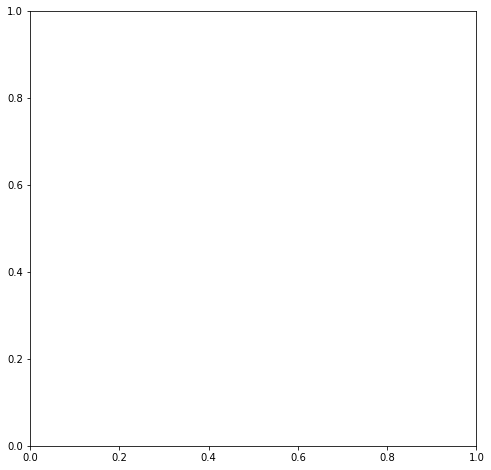

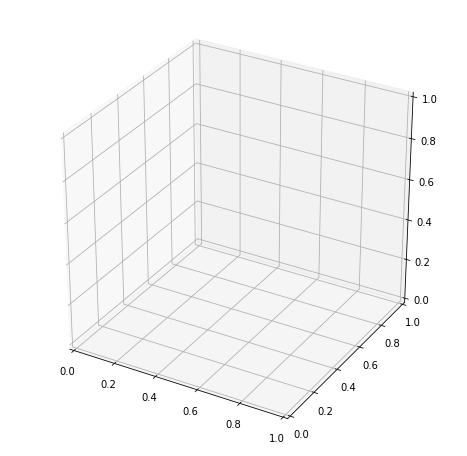

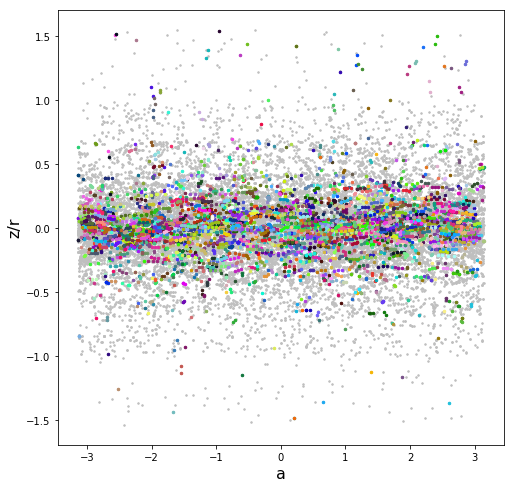

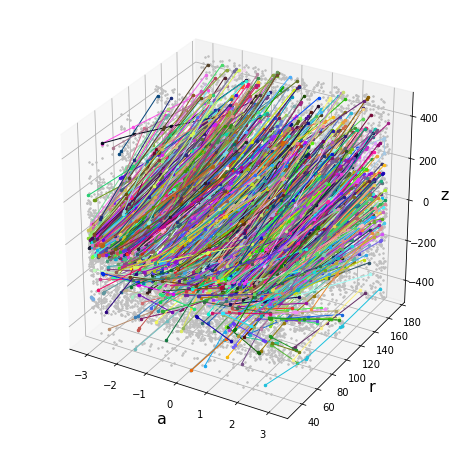

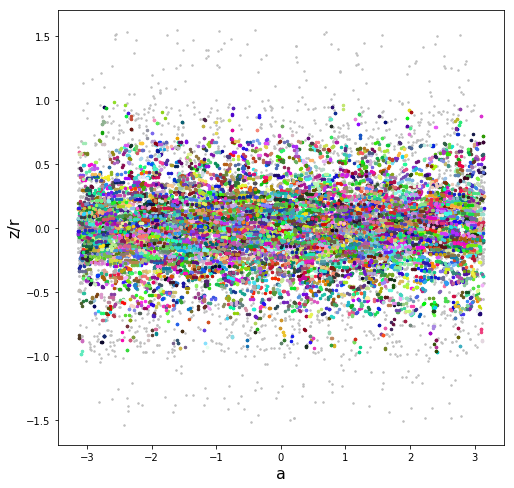

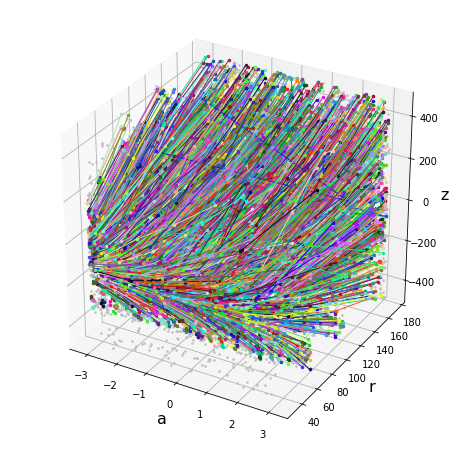

In [5]:
if __name__ == '__main__':

    study_dbscan_for_tracklet_seeding()


